# Bandit-based Online Learning using Thompson Sampling
> The objective of this app is to apply the bandit algorithms to recommendation problems under a simulated environment. Although in practice we will use real data, the complexity of the recommendation problem and associated algorithmic challenges can be realized in this simulated environment.

- toc: true
- badges: false
- comments: true
- categories: [MultiArmedBandit, ThompsonSampling, Simulation. Evaluation]
- image:

## Introduction

Duration: 5

The objective of this app is to apply the bandit algorithms to recommendation problems under a simulated environment. Although in practice we will use real data, the complexity of the recommendation problem and associated algorithmic challenges can be realized in this simulated environment.

### What you'll learn?

- Multi-armed bandit recommender
- Build different bandits from scratch in python
- Simulate and compare performance of bandits
- Build a plotly dash app

### Why is this important?

- Bandits help us to deal with cold-start problem
- Thompson sampling algorithm is powerful method for online learning

### How it will work?

1. Build the prototype
2. Simulate the bandit agent environment
3. Analyze and compare the results
4. Build an interactive dash app

### Who is this for?

- People who are new to bandits concept
- People looking to learn more about bandits and thompson sampling based recommender methods

### Important resources

- [Simulation](https://learnforeverlearn.com/bandits/)
- [Colab notebook](https://colab.research.google.com/github/yfletberliac/rlss-2019/blob/master/labs/MAB.RecoSystems.ipynb)
- [Blog post](https://peterroelants.github.io/posts/multi-armed-bandit-implementation/)
- [Blog post](https://dataorigami.net/blogs/napkin-folding/79031811-multi-armed-bandits)

<!-- ------------------------ -->

## Prototype

Duration: 10

Refer to [this](https://github.com/sparsh-ai/reco-bandit-private/blob/main/app1/prototype1.ipynb) notebook for code.

### Define the number of arms and their probability of winning

```python
# Number of bandits
nb_bandits = 3

# True probability of winning for each bandit
p_bandits = [0.45, 0.55, 0.60]
```

We defined 3 bandits and the probability of winning is 45%, 55%, and 60%. We randomly pull an arm by generating a random number and if that number is less than the bandit probability, we call it a success for that arm and return 1 (positive reward), else return 0 (no reward).

```python
def pull(i):
    """Pull arm of bandit with index `i` and return 1 if win, 
    else return 0."""
    if np.random.rand() < p_bandits[i]:
        return 1
    else:
        return 0
```

### Simulate multi-armed bandit process and update posteriors

The number of trials and wins will represent the prior for each bandit with the help of the Beta distribution.

```python

trials = [0, 0, 0]  # Number of times we tried each bandit
wins = [0, 0, 0]  # Number of wins for each bandit

n = 1000
# Run the trail for `n` steps
for step in range(1, n+1):
    # Define the prior based on current observations
    bandit_priors = [
        stats.beta(a=1+w, b=1+t-w) for t, w in zip(trials, wins)]
    # Sample a probability theta for each bandit
    theta_samples = [ d.rvs(1) for d in bandit_priors]
    # choose a bandit
    chosen_bandit = np.argmax(theta_samples)
    # Pull the bandit
    x = pull(chosen_bandit)
    # Update trials and wins (defines the posterior)
    trials[chosen_bandit] += 1
    wins[chosen_bandit] += x
```

Here is the probability densite plot (pdf, in short) of the 3 bandits. As we can see, pdf was uniform at the beginning and started converging to the mean of actual probability as the steps increase. 

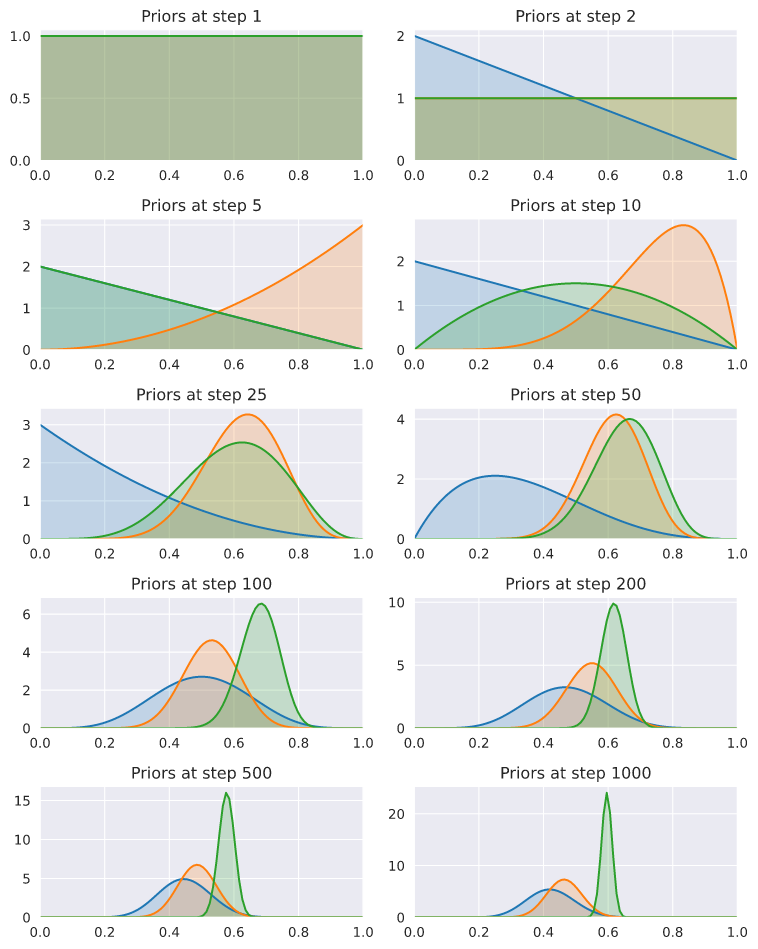

Note: the good thing about beta distribution is that it can take form of both, uniform distribution (at step 1) as well as normal distribution (at step 1000) depending upon the *alpha* and *beta* parameters.

### Final outcome and number of test needed per bandit

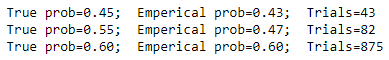

For bandit 1, true probability of success is 45% and agent estimated 43% in 43 trials. Similar case for bandit 2. In case of bandit 3, trials are comparatively large because that one is the highest *probability of success* class and therefore the agent keeps pulling this bandit to maximize the reward.

### Step outcome

We can also see the agent's performance on each step/pull. 

```python
p_bandits = [0.45, 0.55, 0.60]
trials = [0, 0, 0]
wins = [0, 0, 0]
n = 10

for step in range(1, n+1):
    # Define the prior based on current observations
    bandit_priors = [
        stats.beta(a=1+w, b=1+t-w) for t, w in zip(trials, wins)]
    # Sample a probability theta for each bandit
    theta_samples = [
        d.rvs(1) for d in bandit_priors
    ]
    # choose a bandit
    chosen_bandit = np.argmax(theta_samples)
    # Pull the bandit
    x = pull(chosen_bandit)
    # Update trials and wins (defines the posterior)
    trials[chosen_bandit] += 1
    wins[chosen_bandit] += x
    print(p_bandits,trials,wins)
```

For instance, here are the first 10 steps outcome:


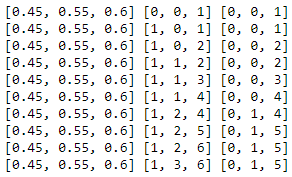

In each row, first list is the probability of success for each bandit, 2nd list is the total count of pull and 3rd list is the total count of win. At step 1, agent pulled third arm and get a reward of 1. At step 2, agent pulled first arm, and get no reward. Then again pulled third arm and get a reward. In first 10 steps, agent pulled 3rd arm 6 times and got a total reward 5 times out of 6. 

But the good thing about the Thompson sampling algorithm is that even this *high reward from the 3rd arm* situation will not stop the agent from exploring from time to time. So if we change the actual probabilities from [0.45, 0.55, 0.6] to let's say [0.9, 0.55, 0.6], the agent will itself identify this change in reward and will start pulling the first arm instead. We will see this live in our app.

<!-- ------------------------ -->

## Simulator app

Duration: 10

Use [this](https://nb.recohut.com/reinforcement%20learning/bandit/dash%20app/2021/06/12/bandit-based-recommender-using-thompson-sampling-app.html) notebook.

### Wrapping the algorithm in a class

We wrapped the thompson sampling algorithm in a class where we defined 2 methods: pull - to draw an arm at random, and step - that will internally pull the arms at random and keep updating the bandit posteriors.

```python
class THSimulationAdv():
    def __init__(self, nb_bandits):
        self.nb_bandits = nb_bandits
        self.trials = [0] * self.nb_bandits
        self.wins = [0] * self.nb_bandits
    def pull(self, i, p_bandits):
        if np.random.rand() < p_bandits[i]:
            return 1
        else:
            return 0
    def step(self, p_bandits):
        # Define the prior based on current observations
        bandit_priors = [stats.beta(a=1+w, b=1+t-w) for t, w in zip(self.trials, self.wins)]
        # Sample a probability theta for each bandit
        theta_samples = [d.rvs(1) for d in bandit_priors]
        # choose a bandit
        chosen_bandit = np.argmax(theta_samples)
        # Pull the bandit
        x = self.pull(chosen_bandit, p_bandits)
        # Update trials and wins (defines the posterior)
        self.trials[chosen_bandit] += 1
        self.wins[chosen_bandit] += x
        return self.trials, self.wins
```

### Dash app

We are creating the rows and columns design using dash bootstrap library. In layout, we defined a button, a create table method, an interval component and a placeholder for probability update callback.

```python
def create_row(nb=1, wd=1, pb='0.5'):
    return dbc.Row(children=[
        dbc.Col(dbc.Input(id='bandit{}_prob'.format(str(nb)), type="number", min=0, max=1, 
                          step=0.01, value=pb), width=wd),
        dbc.Col(dbc.Card(html.Div(id='bandit{}_hits'.format(str(nb))), color="success"),width=wd),
        dbc.Col(dbc.Card(html.Div(id='bandit{}_miss'.format(str(nb))), color="danger"),width=wd),
        dbc.Col(dbc.Card(html.Div(id='bandit{}_total'.format(str(nb))), color="light"),width=wd),
    ], align="center", justify="start")

def create_table():
    row_list = [create_row(nb=i) for i in range(1,n_bandits+1)]
    return html.Div(row_list)

app.layout = html.Div(children=[
    dbc.Button("Start Simulation", color="primary"),
    create_table(),
    dcc.Interval(
            id='interval-component',
            interval=1000, # in milliseconds
            n_intervals=0
        ),
    html.Div(id='p_bandits'),
])
```

We are defining 2 callbacks: first callback will gets triggered when we change the probability (in the first column of the app), and the second callback will gets triggered on a regular interval. We are using 1000 ms (1 sec) as the interval and you can change it up or down. 

```python
p_bandits = [np.random.rand() for i in range(n_bandits)]
last_update = thsim.step(p_bandits)

input_list = [eval(f"Input('bandit{i}_prob', 'value')") for i in range(1,n_bandits+1)]

@app.callback(
    Output('p_bandits', 'children'),
    input_list)
def update_probs(*args):
    global p_bandits
    p_bandits = [float(prob) for prob in args] 
    return ""

output_list_hits = [eval(f"Output('bandit{i}_hits', 'children')") for i in range(1,n_bandits+1)]
output_list_miss = [eval(f"Output('bandit{i}_miss', 'children')") for i in range(1,n_bandits+1)]
output_list_total = [eval(f"Output('bandit{i}_total', 'children')") for i in range(1,n_bandits+1)]
output_list = list(itertools.chain(output_list_hits,
                                   output_list_miss,
                                   output_list_total)
                  )

@app.callback(
    output_list,
    Input('interval-component', 'n_intervals'))
def update_metrics(n):
    x = thsim.step(p_bandits)
    totals = x[0]
    hits = x[1]
    global last_update
    hitlist=[]; misslist=[]; totallist=[]
    for i in range(n_bandits):
        hit_style = green_button_style if hits[i]!=last_update[1][i] else white_button_style
        miss_style = red_button_style if (totals[i]-hits[i])!=(last_update[0][i]-last_update[1][i]) else white_button_style
        hitlist.append(html.Div(hits[i], style=hit_style))
        misslist.append(html.Div(totals[i]-hits[i], style=miss_style))
        totallist.append(totals[i])
    last_update = deepcopy(x)
    return list(itertools.chain(hitlist,misslist,totallist))
```

Demo: [https://www.youtube.com/watch?v=ND04S_0fRjs](https://www.youtube.com/watch?v=ND04S_0fRjs)

Let's take the scenario of an e-commerce. There is a customer named Linda and 10 products in our catalog. At the beginning, there is a 50-50 chance of purchasing any product. Now we changed the probability of one of the arm to 0.85 which means if we recommend that product to Linda, there is a 85% probability that she can buy this product. The agent found that information, simply by exploring the environment, and starts recommending that product to Linda.

*Preferences change*. Now there is another product with 90% chances that Linda can buy if we recommend that. And the probability of old one decreases to 65%. Can our agent find this information by itself? For some steps, it keeps recommending that 7th product but soon realized that reward is not that good now. So the agent started exploring more to see what Linda likes now. 

At this moment, there is a negative reward of 2 for that 3rd product and therefore agent is quite scared to recommend that. But it took the risk and got a reward. Then after some time, it recommended it again and got a reward. Then again, and again, and again. and it started recommending that one. We got the answer: our agent is able to find the information by itself.

It is important to note here that the agent can not see the ground truth probabilities of success (first column in the video image). In real life, this ground truth can be the probability of purchasing a product, probability of reading a news article, or numerous other choice.  And the agent can play the role of a recommender system whose job is to explore the environment and recommend the items to maximize the reward. In e-commerce, reward can be a view/click/buy/add-to-cart event. In entertainment domain, reward can be a watch/add-to-playlist/like event.

<!---------------------------->

## Conclusion

Duration: 2

Congratulations!

### Links and References

- [Notebook](https://github.com/sparsh-ai/reco-bandit-private/blob/main/app1/prototype1.ipynb)
- [Notebook](https://colab.research.google.com/github/yfletberliac/rlss-2019/blob/master/labs/MAB.RecoSystems.ipynb)
- [Simulation](https://learnforeverlearn.com/bandits/)
- [Blog post](https://peterroelants.github.io/posts/multi-armed-bandit-implementation/)
- [Blog post](https://dataorigami.net/blogs/napkin-folding/79031811-multi-armed-bandits)